In [0]:
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
# Import and check data
df = pd.read_csv("drive/ColabNotebooks/Oil Prices/data/oil prices/BrentOilPrices.csv")
df.head(10)

,Date,Price
0,"May 20, 1987",18.63
1,"May 21, 1987",18.45
2,"May 22, 1987",18.55
3,"May 25, 1987",18.60
4,"May 26, 1987",18.63
5,"May 27, 1987",18.60
6,"May 28, 1987",18.60
7,"May 29, 1987",18.58
8,"Jun 01, 1987",18.65
9,"Jun 02, 1987",18.68


In [3]:
# Convert dates (May 21, 1987 to 1987-05-20)
date_parse = lambda x: pd.datetime.strptime(x, '%b %d, %Y')
df['Date'] = df['Date'].apply(date_parse)
df.set_index('Date', inplace=True)
df.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [4]:
# Check nulls
df.isna().sum()

Price    0
dtype: int64

In [5]:
# Check dates
df.index

DatetimeIndex(['1987-05-20', '1987-05-21', '1987-05-22', '1987-05-25',
               '1987-05-26', '1987-05-27', '1987-05-28', '1987-05-29',
               '1987-06-01', '1987-06-02',
               ...
               '2019-09-17', '2019-09-18', '2019-09-19', '2019-09-20',
               '2019-09-23', '2019-09-24', '2019-09-25', '2019-09-26',
               '2019-09-27', '2019-09-30'],
              dtype='datetime64[ns]', name='Date', length=8216, freq=None)

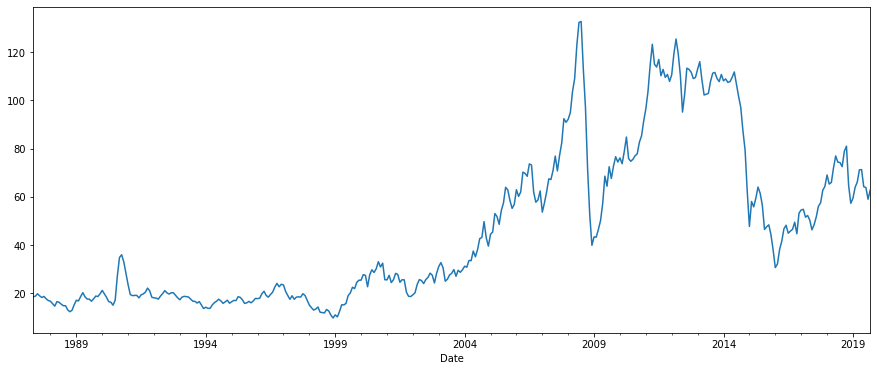

In [6]:
# Plot means of months of prices
df['Price'].resample('MS').mean().plot(figsize=(15, 6))

In [0]:
# Normalize data
sc = MinMaxScaler(feature_range=(0, 1))
df = sc.fit_transform(df)

In [0]:
# Split data
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
train_scaled, test_scaled = df[0:train_size, :], df[train_size:len(df), :]

In [0]:
# Func for batches
def next_batch(training_data, steps):
    random_start = np.random.randint(0, len(training_data)-steps)
    y_data = np.array(training_data[random_start:random_start+steps+1]).reshape(1, steps+1)
    return y_data[:, :-1].reshape(-1, steps, 1), y_data[:, 1:].reshape(-1, steps, 1)

In [10]:
# Fitting
tf.reset_default_graph()

num_inputs = 1
num_outputs = 1
num_neurons = 100
num_time_steps = 90
learning_rate = 0.001
num_training_iterations = 1000

x = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.GRUCell(
    num_units=num_neurons, activation=tf.nn.relu), output_size=num_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()

train_loss = []
validation_loss = []
with tf.Session() as sess:
  sess.run(init)
  for i in range(num_training_iterations):
    x_train_batch, y_train_batch = next_batch(train_scaled, num_time_steps)
    x_test_batch, y_test_batch = next_batch(test_scaled, num_time_steps)
    sess.run(train, feed_dict={x: x_train_batch, y: y_train_batch})
    train_mse = loss.eval(feed_dict={x: x_train_batch, y: y_train_batch})
    test_mse = loss.eval(feed_dict={x: x_test_batch, y: y_test_batch})
    train_loss.append(train_mse)
    validation_loss.append(test_mse)
    if i % 100 == 0:
        print(i, "\tTrain MSE: {} - Test MSE: {}".format(train_mse, test_mse))
  predicted = outputs.eval(feed_dict={x: test_scaled[:90].reshape(-1, 90, 1), y: test_scaled[:90].reshape(-1, 90, 1)})

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
0 	Train MSE: 0.0049086809158325195 - Test MSE: 0.032191019505262375
100 	Train MSE: 0.0005781078943982

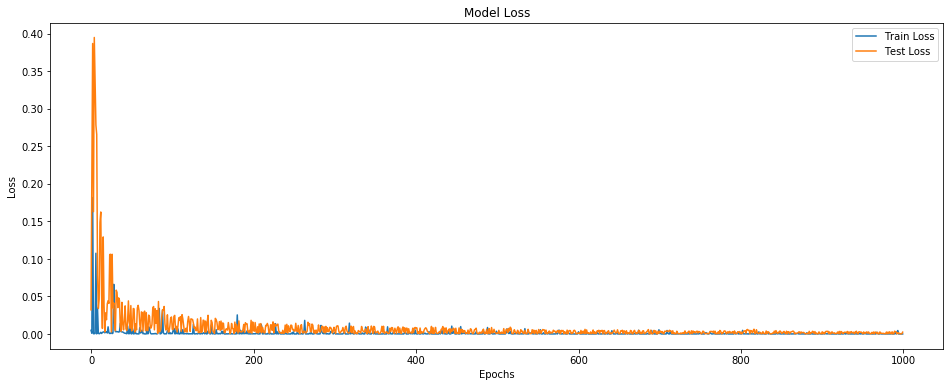

In [13]:
# Train loss & validation loss graphs
plt.figure(figsize=(16, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(validation_loss, label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

In [0]:
# Inverse transforms
predicted_inverse_transformed = sc.inverse_transform(predicted[0])
test_unscaled = sc.inverse_transform(test_scaled)

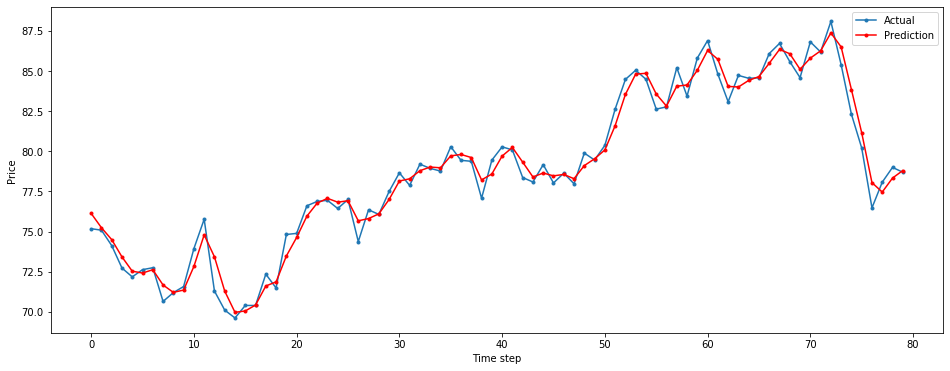

In [22]:
# Compare real and predicted values
plt.figure(figsize=(16, 6))
plt.plot(test_unscaled[10:90], marker='.', label="Actual")
plt.plot(predicted_inverse_transformed[10:], 'r', marker='.', label="Prediction")
plt.ylabel('Price')
plt.xlabel('Time step')
plt.legend()